Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.

Training DenseNet121 Model...


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4149 - loss: 1.4600 - val_accuracy: 0.5728 - val_loss: 0.9689
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5500 - loss: 1.0292 - val_accuracy: 0.7184 - val_loss: 0.6974
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6113 - loss: 0.9184 - val_accuracy: 0.7184 - val_loss: 0.7695
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7049 - loss: 0.7236 - val_accuracy: 0.6893 - val_loss: 0.6987
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6800 - loss: 0.7189 - val_accuracy: 0.7282 - val_loss: 0.6673
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7149 - loss: 0.6658 - val_accuracy: 0.6893 - val_loss: 0.6983
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7230 - loss: 0.6673 - val_accuracy: 0.7282 - val_loss: 0.6814
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7823 - loss: 0.5816 - val_accuracy: 0.7379 - val_loss:

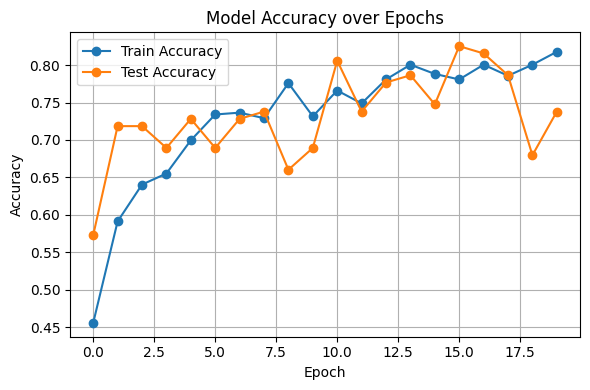

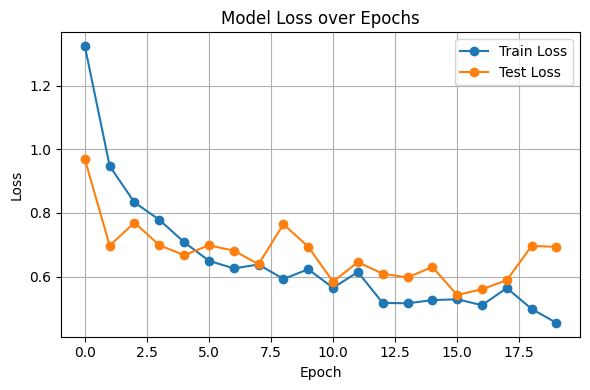

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# ---- Set Random Seed for Reproducibility ----
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 16
dropout_rate = 0.5
learning_rate = 0.001
target_size = (224, 224)  # DenseNet input size
num_classes = 3 

# ---- Data Preprocessing ----
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed   
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

def build_model(base_model):
    base_model.trainable = False  # Freeze base layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=output)

# ---- DenseNet121 Model ----
densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model(densenet121_base)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining DenseNet121 Model...")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

# ✅ Save Training History
model_name = "DenseNet121(new)_5FCV"
history_filename = f"training_history_{model_name}.pkl"

with open(history_filename, 'wb') as f:
    pickle.dump(history.history, f)

print(f"✅ Training history saved as {history_filename}!")

# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"🟢 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"🔴 Test Loss: {test_loss:.4f}")

# ---- Evaluate Training Performance ----
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"🟢 Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"🔴 Training Loss: {train_loss:.4f}")

val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"🟢 Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"🔴 Final Validation Loss: {val_loss:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.76      0.77      0.77       500
               Nor       0.89      0.98      0.93       500
Squamous_carcinoma       0.85      0.75      0.80       500

          accuracy                           0.84      1500
         macro avg       0.83      0.84      0.83      1500
      weighted avg       0.83      0.84      0.83      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.92      0.56      0.70        39
               Nor       0.80      0.77      0.79        31
Squamous_carcinoma       0.61      0.91      0.73        33

          accuracy                           0.74       103
         macro avg       0.78      0.75      0.74       103
      weighted avg       0.78      0.74      0.74       103

Validation Accuracy: 0.836
Va

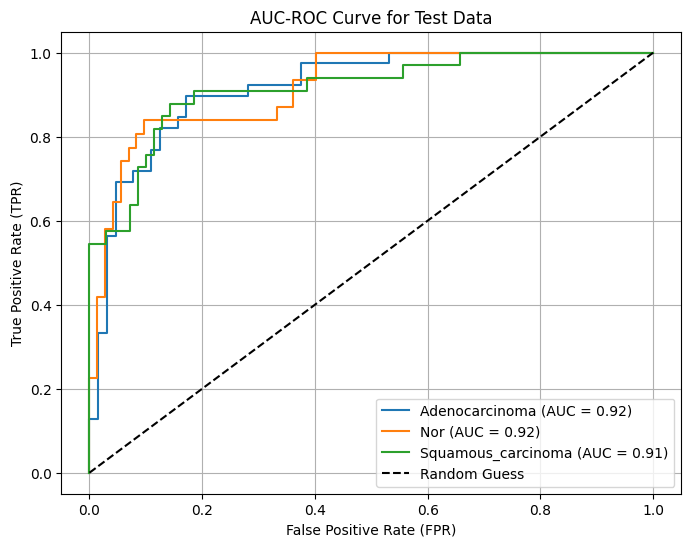


Macro-Averaged Test AUC: 0.92
94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.91
Nor - AUC: 1.00
Squamous_carcinoma - AUC: 0.95


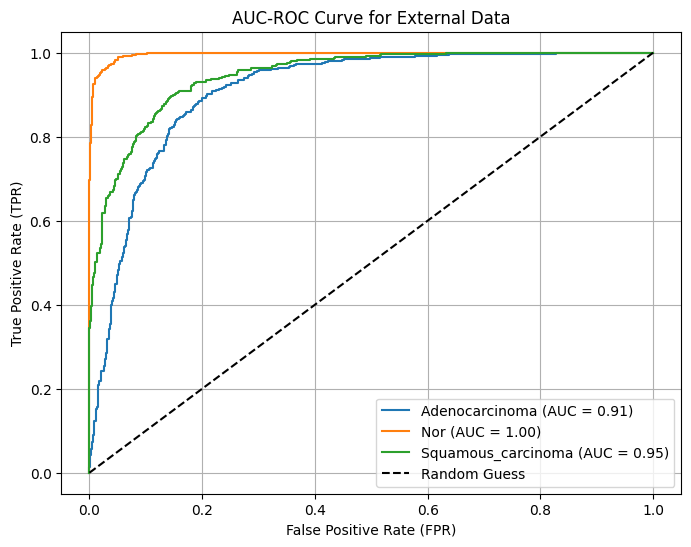


Macro-Averaged Test AUC: 0.95


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")